# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

<IPython.core.display.Javascript object>


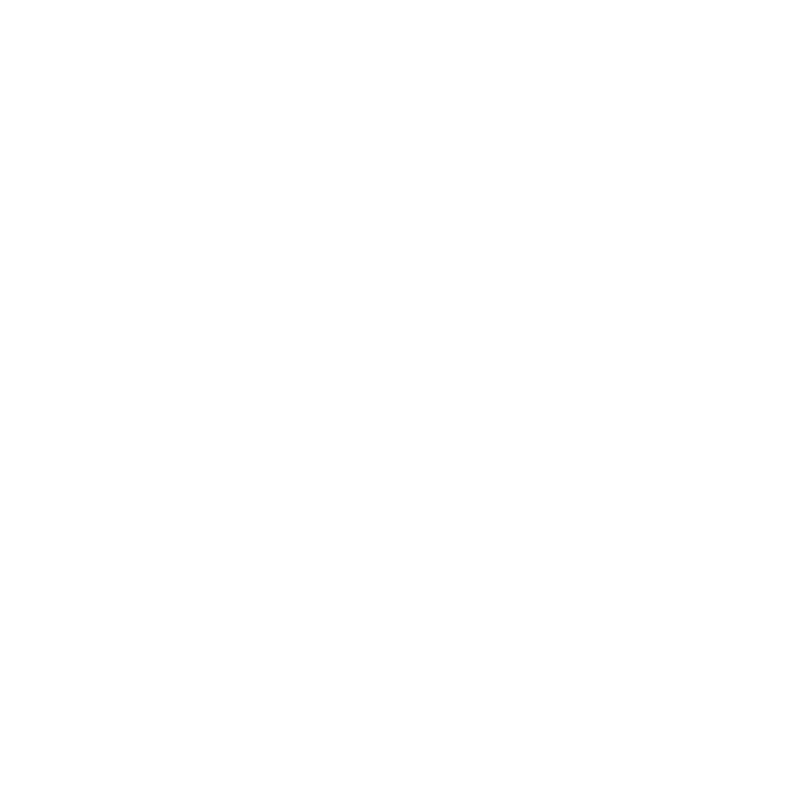

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplleaflet
import pandas as pd
import numpy as np
%matplotlib notebook

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [7]:
def get_weather_records():
    df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
    df = df[df['Date'].str.contains('2015-') == False]
    df['Date'] = df['Date'].str[5:]
    df = df[df['Date'] != '02-29'].reset_index(drop=True)
    min_df = df.loc[df[df['Element'] == 'TMIN'].groupby(df['Date'])['Data_Value'].idxmin()].copy().set_index('Date').loc[:,['ID','Data_Value']]
    max_df = df.loc[df[df['Element'] == 'TMAX'].groupby(df['Date'])['Data_Value'].idxmax()].copy().set_index('Date').loc[:,['ID','Data_Value']]
    recs_df = min_df.merge(right = max_df, how = 'inner', left_index = True, right_index =True)
    recs_df = recs_df.drop(['ID_x','ID_y'],axis = 1).rename(columns= {'Data_Value_x':'RTMIN', 'Data_Value_y':'RTMAX'})
    return recs_df

In [8]:
def check_record_broken():
    total_df = get_weather_records()
    df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
    df = df[df['Date'].str.contains('2015-') == True]
    df['Date'] = df['Date'].str[5:]
    min_df = df.loc[df[df['Element'] == 'TMIN'].groupby(df['Date'])['Data_Value'].idxmin()].copy().set_index('Date').loc[:,['ID','Data_Value']]
    max_df = df.loc[df[df['Element'] == 'TMAX'].groupby(df['Date'])['Data_Value'].idxmax()].copy().set_index('Date').loc[:,['ID','Data_Value']]
    total_df = total_df.merge(right = min_df, how = 'inner', left_index = True, right_index = True)
    total_df = total_df.merge(right = max_df, how = 'inner', left_index = True, right_index = True)
    total_df = total_df.rename(columns= {'Data_Value_x':'TMIN15', 'Data_Value_y':'TMAX15'}).drop(['ID_x','ID_y'],axis = 1)
    broken_df = pd.DataFrame(min_df.index)
    broken_df['BTMIN'] = list(total_df.apply(lambda x:x['TMIN15'] if x['TMIN15'] < x['RTMIN'] else None, axis = 1))
    broken_df['BTMAX'] = list(total_df.apply(lambda x:x['TMAX15'] if x['TMAX15'] > x['RTMAX'] else None, axis = 1))
    broken_df = broken_df.set_index('Date')
    return broken_df

<IPython.core.display.Javascript object>


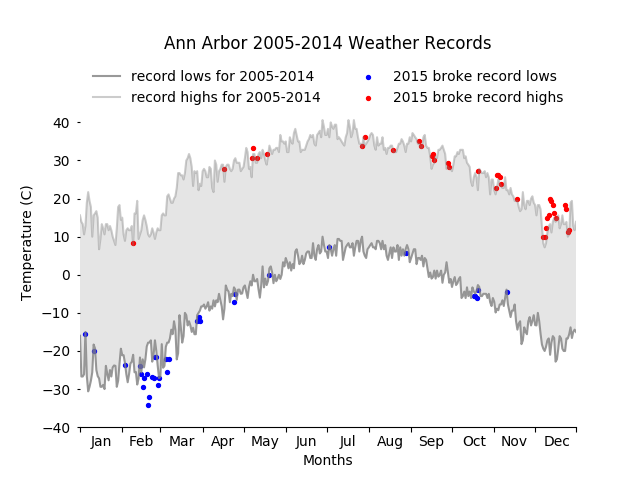

Text(0,0.5,'Temperature (C)')

In [9]:
recs_df = get_weather_records()

plt.figure()
line1, = plt.plot(list(recs_df['RTMIN'] * 0.1), '-', c = 'grey', alpha = 0.8)
line2, = plt.plot(list(recs_df['RTMAX'] * 0.1), '-', c = 'grey', alpha = 0.4)
plt.title('Ann Arbor 2005-2014 Weather Records')

cax = plt.gca()
cax.axis([0,364,-40,57])
cax.fill_between(range(len(recs_df.index)), 
                       list(recs_df['RTMIN'] * 0.1), list(recs_df['RTMAX'] * 0.1), 
                       facecolor='grey', 
                       alpha=0.2)

month_names = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
ndays = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
mstarts = np.array([])
centres = np.array([])
for i in range(12):
    mstarts = np.append(mstarts, ndays[:i].sum()).astype(int)
mstarts = np.append(mstarts, 364).astype(int)

for i in range(12):
    centres = np.append(centres, ndays[:i].sum()+(ndays[i]+1)/2).astype(int)
#mstarts
cax.xaxis.set_major_locator(ticker.FixedLocator(mstarts))
cax.xaxis.set_major_formatter(ticker.NullFormatter())
cax.xaxis.set_minor_locator(ticker.FixedLocator(centres))
cax.xaxis.set_minor_formatter(ticker.FixedFormatter(month_names))
cax.yaxis.set_major_locator(ticker.FixedLocator(list(range(-40, 41, 10))))

for tick in cax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)


for tick in cax.yaxis.get_major_ticks():
    tick.tick1line.set_markersize(2)
    tick.tick2line.set_markersize(2)
    
broken_df = check_record_broken()
points1 = cax.scatter(list(range(len(broken_df.index))), list(broken_df['BTMIN'] * 0.1), s = 8, c = 'blue')
points2 = cax.scatter(list(range(len(broken_df.index))), list(broken_df['BTMAX'] * 0.1), s = 8, c = 'red')

cax.spines['top'].set_visible(False)
cax.spines['right'].set_visible(False)
cax.spines['left'].set_visible(False)

cax.legend((line1, line2, points1, points2),
           ('record lows for 2005-2014', 'record highs for 2005-2014', '2015 broke record lows', '2015 broke record highs'), 
           loc = 'upper right', ncol=2, mode='expand', frameon = False)
cax.set_xlabel('Months')
cax.set_ylabel('Temperature (C)')

In [ ]:
plt.savefig('weather_records.jpg', format='jpg', dpi=1200)